In [1]:
#reasonably good model when incorporating all information including chemistry,
#...far better than just geo + aerial only
#maybe oversampling will help with more features for this limited dataset for Colorado??
#sort of a limited dataset for Colorado only - probably need more data for better results

# Import dependencies
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#database
from sqlalchemy import create_engine
from sqlalchemy import join
from sqlalchemy.sql import select

#from config import db_password
import psycopg2

#import machines learning modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier

from numpy import loadtxt
from xgboost import plot_importance
import xgboost as xgboost

#mapping using geopandas, descartes & shapely
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inlin

In [2]:
# Create an engine instance
conn_string= databasestringpasswordhere
alchemyEngine=create_engine(conn_string)

# Connect to PostgreSQL server
dbConnection = alchemyEngine.connect();

# Read data from PostgreSQL database table and load into a DataFrame instance, countries not included here, but could add
age = pd.read_sql("select * from \"Age\"", dbConnection);
computed = pd.read_sql("select * from \"Computed\"", dbConnection)
#country = pd.read_sql("select * from \"Country\"", dbConnection)
isotope = pd.read_sql("select * from \"Isotope\"", dbConnection)
major = pd.read_sql("select * from \"Major\"", dbConnection)
rockgroup = pd.read_sql("select * from \"Rockgroup\"", dbConnection)
trace = pd.read_sql("select * from \"Trace\"", dbConnection)
sample = pd.read_sql("select * from \"Sample\"", dbConnection)
colorado=pd.read_sql("select * from \"Colorado_input_data\"", dbConnection)

pd.set_option('display.expand_frame_repr', False);
dbConnection.close();

In [3]:
#add another dataset from usgs
# Create an engine instance
conn_string= databasestringpasswordhere
alchemyEngine=create_engine(conn_string)

# Connect to PostgreSQL server
dbConnection = alchemyEngine.connect();

# Read data from PostgreSQL database table and load into a DataFrame instance, countries not included here, but could add
mines = pd.read_sql("select * from \"mines\"", dbConnection)

pd.set_option('display.expand_frame_repr', False);
dbConnection.close();

In [9]:
a = sample.join(trace.set_index('trace_id'), on='trace_id', how = 'left')
b = a.join(major.set_index('major_id'), on='major_id', how = 'left')
c = b.join(isotope.set_index('iso_id'), on = 'iso_id', how = 'left')
d = c.join(age.set_index('age_id'), on = 'age_id', how = 'left')
e = d.join(computed.set_index('comp_id'), on = 'comp_id', how ='left')
f = e.join(colorado.set_index('sample_id'), on='sample_id', how='inner')
df = f.join(rockgroup.set_index('rgroup_id'), on = 'rgroup_id', how = 'left')


#df = fulldataframe - can continue on with this one! 


In [10]:
#encode some of the categorical values: 
# Drop for sure: sample name, time period min/max/sd overlaps with time_period, 
# Rock name overlaps with rock type, age method

#need to group:  time period, rock facies
#good to go for enconding - rock group, rock origin

#Rock group encoding
dummy_rock_group = pd.get_dummies(df["rock_group"])
df=pd.concat([df,dummy_rock_group], axis=1)
df=df.drop(['rock_group'], axis = 1)

#rock origin encoding
dummy_rock_origin = pd.get_dummies(df["rock_origin"])
df=pd.concat([df,dummy_rock_origin], axis=1)
df=df.drop(['rock_origin'], axis = 1)

In [11]:

#need to group time period
# Determine which values to replace if counts are less than 3000
time_period_counts = df["time_period"].value_counts()
replace_time_period = list(time_period_counts[time_period_counts<3000].index)

# Replace in dataframe
for app in replace_time_period:
    df.time_period = df.time_period.replace(app,"Other_time_period")
    
dummy_time = pd.get_dummies(df["time_period"])
df=pd.concat([df,dummy_time], axis=1)
df=df.drop(['time_period'], axis = 1)

In [12]:
#need to group rock facies
# Determine which values to replace if counts are less than 1000
rock_facies = df["rock_facies"].value_counts()
replace_rock_facies = list(rock_facies[rock_facies<1000].index)

# Replace in dataframe
for app in replace_rock_facies:
    df.rock_facies = df.rock_facies.replace(app,"Other_facies")
    
dummy_facies = pd.get_dummies(df["rock_facies"])
df=pd.concat([df,dummy_facies], axis=1)
df=df.drop(['rock_facies'], axis = 1)

In [13]:
#Pm not included because no entries in there
#Keep a copy of df with everything
#add up rare earths 
#add fillna(0) because na values were causing some issues and did not add things up when there was a na value
df2=df
df2['rare_earth'] = (df['sc_ppm'].fillna(0)+df['y_ppm'].fillna(0)+df['la_ppm'].fillna(0)+df['ce_ppm'].fillna(0)+df['pr_ppm'].fillna(0)+df['nd_ppm'].fillna(0)+df['sm_ppm'].fillna(0)+df['eu_ppm'].fillna(0)+df['gd_ppm'].fillna(0)+df['tb_ppm'].fillna(0)+df['dy_ppm'].fillna(0)+df['ho_ppm'].fillna(0)+df['er_ppm'].fillna(0)+ df['tm_ppm'].fillna(0)+df['yb_ppm'].fillna(0)+df['lu_ppm'].fillna(0))

In [14]:
#drop individual rare earths
df2 = df.drop(['sc_ppm', 'y_ppm', 'la_ppm', 'ce_ppm', 'pr_ppm', 'nd_ppm', 'sm_ppm', 'eu_ppm', 'gd_ppm', 'tb_ppm', 'dy_ppm', 'ho_ppm', 'er_ppm', 'tm_ppm', 'yb_ppm', 'lu_ppm'], axis=1)

In [15]:
df2.head()

,sample_id,sample_name,latitude,longitude,rock_name,quartz,feldspar,lithics,p_velocity,density_model,heat_production,heat_production_mass,trace_id,iso_id,comp_id,major_id,rgroup_id,age_id,country_id,f_ppm,cl_ppm,br__ppm,i_ppm,h_ppm,c_ppm,n_ppm,p_ppm,s_ppm,al_ppm,as_ppm,ag_ppm,au_ppm,b_ppm,ba_ppm,be_ppm,bi_ppm,ca_ppm,cd_ppm,co_ppm,cr_ppm,cs_ppm,cu_ppm,fe_ppm,ga_ppm,ge_ppm,hf_ppm,hg_ppm,in_ppm,ir_ppm,k_ppm,li_ppm,mg_ppm,mn_ppm,mo_ppm,na_ppm,ni_ppm,nb_ppm,os_ppm,pa_ppm,pb_ppm,pd_ppm,pm_ppm,pt_ppm,rb_ppm,re_ppm,rh_ppm,ru_ppm,sb_ppm,se_ppm,si_ppm,sn_ppm,sr_ppm,ta_ppm,te_ppm,th_ppm,ti_ppm,tl_ppm,w_ppm,v_ppm,u_ppm,zn_ppm,zr_ppm,sio2,tio2,al2o3,cr2o3,fe2o3,fe2o3_tot,feo,feo_tot,mgo,cao,mno,nio,k2o,na2o,sro,p2o5,h2o_plus,h2o_minus,h2o_tot,co2,so3,bao,caco3,mgco3,loi,rb87_sr86,sr87_sr86,nd143_nd144,sm147_nd144,lu176_hf177,hf176_hf177,re187_os186,re187_os188,os187_os188,pb206_pb204,pb207_pb204,pb208_pb204,th232_pb204,th232_u238,u238_pb204,epsilon_hf,epsilon_nd,epsilon_sr,age_min,age,age_max,age_sd,time_period_min,time_period_max,age_method,mg_number,fe_number,mali,asi,maficity,cia,wip,spar,qtzindex,r1,r2,rock_type,totmag,resmag,resmagCM4,Distance,qual,app_K,app_U,app_Th,U_Th_ratio,U_K_ratio,Th_K_ratio,total_count,atmos_BI214,air_temp,air_press,igneous,metamorphic,sedimentary,chemical,metaigneous,metaplutonic,metasedimentary,metavolcanic,plutonic,volcanic,,Other_time_period,Other_facies,rare_earth
80261,80325,t84152,37.25,-106.00,trachybasalt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71938,666061,661994,771361,17,43332,210,NaN,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,-1.0,NaN,NaN,NaN,78.0,245.0,NaN,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.0,NaN,375.0,NaN,NaN,NaN,-10.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,0.111,NaN,NaN,95.0,NaN,NaN,NaN,NaN,NaN,NaN,199.0,NaN,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,NaN,NaN,7.861588,1.089044,NaN,52.131205,NaN,-0.004805,0.219919,2.833779,NaN,granite,54213.8,53640.0,304.0,1157.280330,682.0,131.0,28.0,39.0,0.7,0.2,0.3,1686.0,-99.9,8.3,-999.9,1,0,0,0,0,0,0,0,0,1,0,1,0,91.96
80302,80302,419x,38.33,-105.50,carbonatite,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66176,666068,661994,734233,11,43325,210,6100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,8.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.0,NaN,NaN,25.0,NaN,NaN,7.0,NaN,None,NaN,894.0,NaN,NaN,NaN,NaN,-2.000,NaN,45.0,10.0,NaN,NaN,11.0,NaN,NaN,11.0,3.0,19.0,55.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,NaN,NaN,7.861588,1.089044,NaN,52.131205,NaN,-0.004805,0.219919,2.833779,NaN,granite,55136.0,130.1,526.0,399.620166,0.0,2.5,3.4,9.7,0.3,1.4,3.9,2487.3,2.4,-2.8,556.5,1,0,0,0,0,0,0,0,1,0,0,1,0,35.00
80303,80303,t84152,37.25,-106.00,trachybasalt,NaN,NaN,NaN,7.068878,2923.239352,NaN,NaN,81475,484199,184212,682674,17,43415,210,NaN,3660.0,NaN,NaN,NaN,NaN,NaN,NaN,304.0,NaN,NaN,NaN,NaN,NaN,541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.0,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,591.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,0.425045,0.739362,-6.120000,0.697295,0.322335,41.082734,71.762758,-0.235224,0.091750,1.461196,1.593819,alkalic basalt,54213.8,53640.0,304.0,1157.280330,682.0,131.0,28.0,39.0,0.7,0.2,0.3,1686.0,-99.9,8.3,-999.9,1,0,0,0,0,0,0,0,0,1,0,1,0,0.00
80304,80304,t84163,37.14,-105.82,trachybasalt,NaN,NaN,NaN,6.863169,2847.002910,NaN,NaN,81475,276718,247699,626282,17,18096,210,NaN,3660.0,NaN,NaN,NaN,NaN,NaN,NaN,304.0,NaN,NaN,NaN,NaN,NaN,541.0,NaN,NaN,NaN,NaN,N

In [16]:
#drop some additional items
df3=df2.drop(
['sample_name', 'rock_name','pm_ppm', 'time_period_min', 'time_period_max', 'age_method', 'rock_type', 'air_temp', 
'air_press','sample_id','latitude','longitude', 'age_max', 'age_min', 'age_sd','trace_id', 'iso_id', 'comp_id', 'major_id', 'rgroup_id', 'age_id','country_id'],axis=1)

In [17]:
#Keep the data where rare earths > 1, assume rare earths = 0 did not have assays

df_rare_earth=df3.loc[df3['rare_earth'] >1]
df_rare_earth.describe()


,quartz,feldspar,lithics,p_velocity,density_model,heat_production,heat_production_mass,f_ppm,cl_ppm,br__ppm,i_ppm,h_ppm,c_ppm,n_ppm,p_ppm,s_ppm,al_ppm,as_ppm,ag_ppm,au_ppm,b_ppm,ba_ppm,be_ppm,bi_ppm,ca_ppm,cd_ppm,co_ppm,cr_ppm,cs_ppm,cu_ppm,fe_ppm,ga_ppm,ge_ppm,hf_ppm,hg_ppm,in_ppm,ir_ppm,k_ppm,li_ppm,mg_ppm,mn_ppm,mo_ppm,na_ppm,ni_ppm,nb_ppm,os_ppm,pa_ppm,pb_ppm,pd_ppm,pt_ppm,rb_ppm,re_ppm,rh_ppm,ru_ppm,sb_ppm,se_ppm,si_ppm,sn_ppm,sr_ppm,ta_ppm,te_ppm,th_ppm,ti_ppm,tl_ppm,w_ppm,v_ppm,u_ppm,zn_ppm,zr_ppm,sio2,tio2,al2o3,cr2o3,fe2o3,fe2o3_tot,feo,feo_tot,mgo,cao,mno,nio,k2o,na2o,sro,p2o5,h2o_plus,h2o_minus,h2o_tot,co2,so3,bao,caco3,mgco3,loi,rb87_sr86,sr87_sr86,nd143_nd144,sm147_nd144,lu176_hf177,hf176_hf177,re187_os186,re187_os188,os187_os188,pb206_pb204,pb207_pb204,pb208_pb204,th232_pb204,th232_u238,u238_pb204,epsilon_hf,epsilon_nd,epsilon_sr,age,mg_number,fe_number,mali,asi,maficity,cia,wip,spar,qtzindex,r1,r2,totmag,resmag,resmagCM4,Distance,qual,app_K,app_U,app_Th,U_Th_ratio,U_K_ratio,Th_K_ratio,total_count,atmos_BI214,igneous,metamorphic,sedimentary,chemical,metaigneous,metaplutonic,metasedimentary,metavolcanic,plutonic,volcanic,,Other_time_period,Other_facies,rare_earth
count,0.0,0.0,0.0,230.000000,230.000000,180.000000,180.000000,413.000000,180.000000,4.000000,2.000000,0.0,3.000000,0.0,53.000000,145.000000,61.000000,227.000000,139.000000,41.000000,112.000000,440.000000,261.000000,146.000000,103.000000,61.000000,241.000000,407.000000,217.000000,405.000000,132.000000,321.000000,94.000000,185.000000,44.000000,8.00000,3.000000,86.000000,234.000000,105.000000,118.000000,264.000000,23.000000,404.000000,378.000000,0.0,0.0,398.000000,39.000000,16.000000,389.000000,0.0,2.000000,0.0,149.000000,60.000000,0.0,213.000000,432.000000,234.000000,38.000000,347.000000,118.000000,27.000000,94.000000,395.000000,344.000000,400.000000,437.000000,142.000000,146.000000,142.000000,2.00,78.000000,35.000000,76.000000,13.000000,143.000000,149.000000,124.000000,1.00,153.000000,143.000000,0.0,128.000000,18.000000,15.000000,3.000000,39.000000,1.00,2.000000,35.000000,1.0,77.000000,4.000000,7.000000,8.000000,5.000000,0.0,0.0,0.0,2.000000,2.000000,1.0000,1.0000,1.000,0.0,1.000,0.0,0.0,0.0,0.0,193.000000,245.000000,245.000000,444.000000,442.000000,245.000000,443.000000,224.000000,444.000000,443.000000,442.000000,241.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.0,466.0,466.0,466.0,466.0,466.000000,466.000000,466.000000,466.000000,466.0,466.000000
mean,NaN,NaN,NaN,6.833698,2846.738241,1.694695,0.000601,955.908536,415.405838,-0.650000,1.700000,NaN,269.333333,NaN,2519.037853,3838.380156,40903.114754,47.112496,3.042563,1.768705,467.407420,867.282772,3.122460,1.108310,33278.737864,1.222508,24.403591,126.035405,4.477631,94.385984,37167.272727,20.533125,1.544043,5.180062,0.622955,0.08625,0.396667,20096.790698,42.120882,14478.649333,553.288072,23.331039,1062.347826,63.427541,29.942897,NaN,NaN,37.255777,-1.412795,0.820256,130.428670,NaN,-0.002500,NaN,1.236123,0.451835,NaN,4.323172,600.696992,1.681799,2.172479,15.537958,2559.085660,1.083753,283.513783,110.340764,21.096409,98.067791,219.687995,65.920682,0.748556,12.956110,0.01,4.640425,5.016943,3.310986,5.622960,3.454301,4.077740,0.140173,0.01,2.783170,2.862639,NaN,0.371599,1.294444,0.908000,0.872333,3.511795,0.04,0.170000,34.205686,0.0,2.597662,0.832077,0.708081,0.512578,0.148001,NaN,NaN,NaN,0.197675,0.119270,18.8504,15.6192,38.765,NaN,0.882,NaN,NaN,NaN,NaN,11.559229,0.502980,0.654849,3.080498,1.066860,0.248334,48.914795,78.561476,-0.087339,0.178423,2.423749,1.277503,54324.766953,16625.800429,-29.214163,1428.711815,-249.628755,30.874034,7.412446,22.111159,7.068455,-13.055794,21.627468,1229.454292,-22.039056,0.890558,0.107296,0.002146,0.0,0.0,0.0,0.0,0.0,0.130901,0.759657,0.199571,0.800429,0.0,265.491358
std,NaN,NaN,NaN,0.413861,129.876745,1.642259,0.000583,1652.735601,647.450

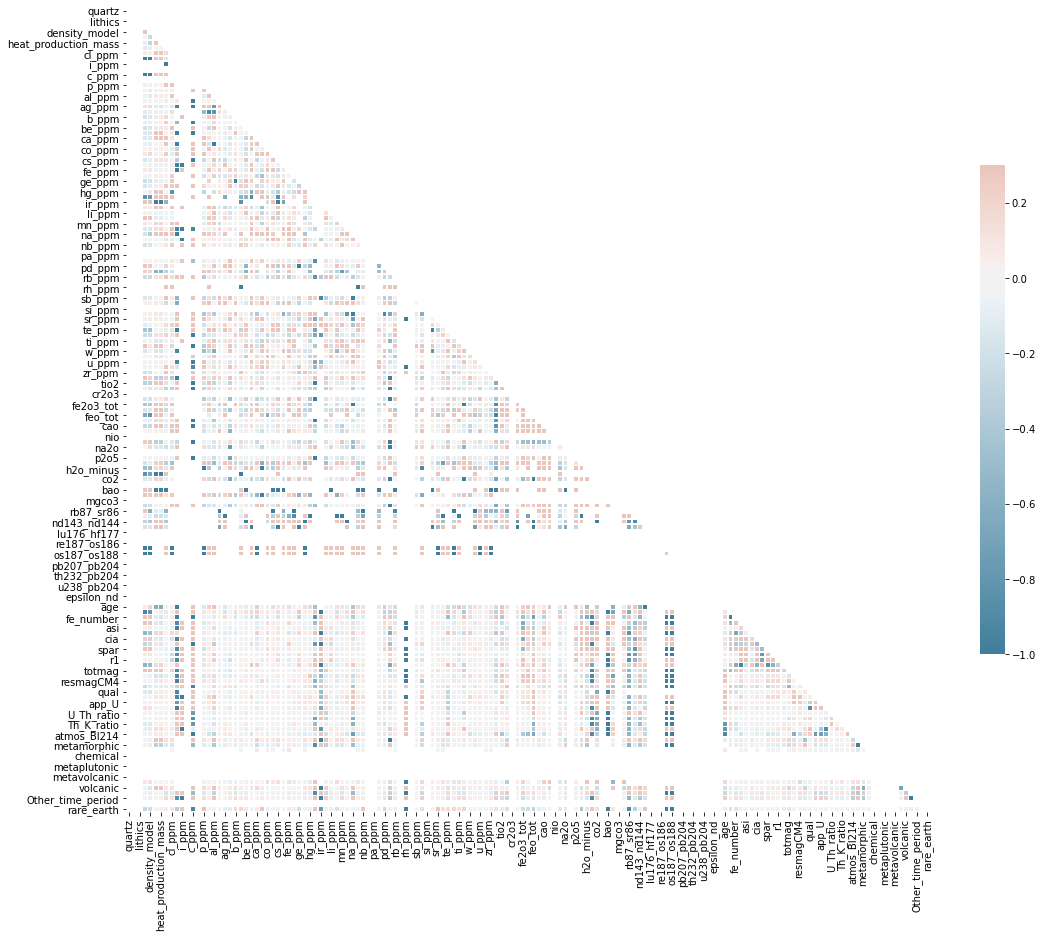

In [18]:
# Compute the correlation matrix
corr = df_rare_earth.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [19]:
#classifer - make 0 and 1 for rare earth column.  
#use 100 to create more rare earth points with small dataset
df_class=df_rare_earth
mask2 = df_class['rare_earth'] < 100
df_class.loc[mask2, 'rare_earth'] = 0
mask = df_class['rare_earth'] >= 100
df_class.loc[mask, 'rare_earth'] = 1

C:\Users\jbike\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [20]:
df_class['rare_earth'].value_counts()

1.0    309
0.0    157
Name: rare_earth, dtype: int64

In [21]:
# Split our preprocessed data into our features and target arrays for regression problems
y = df_class["rare_earth"]
X = df_class.drop(["rare_earth"], axis = 1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [22]:
#use decision tree to see if that improves and look at shap plot to determine relative importance of parameters
#best was combo of reduced threshold, down to 100 for cut off for rare earths and a lower scale_pos_weight 
model = XGBClassifier(enable_categorical=True,scale_pos_weight = 3 )
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score: %f" % (accuracy))

C:\Users\jbike\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { enable_categorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:52:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RMSE: 0.462250
Accuracy score: 0.786325


In [23]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Displaying results
print("Confusion Matrix")
display(cm_df)

#accuracy score ok, but confusion matrix = not good!

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,26,15
Actual 1,10,66


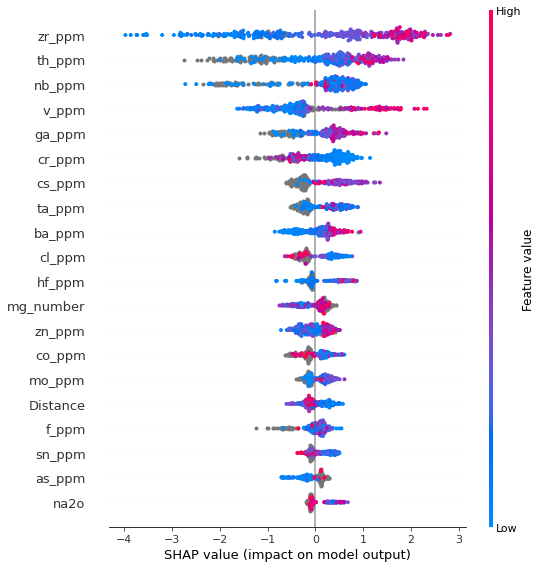

In [24]:
#look at feature importance
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

#maybe bring in age, totmag, U_Th_ratio, resmagCM4, app_U into the main model and see if improves performance

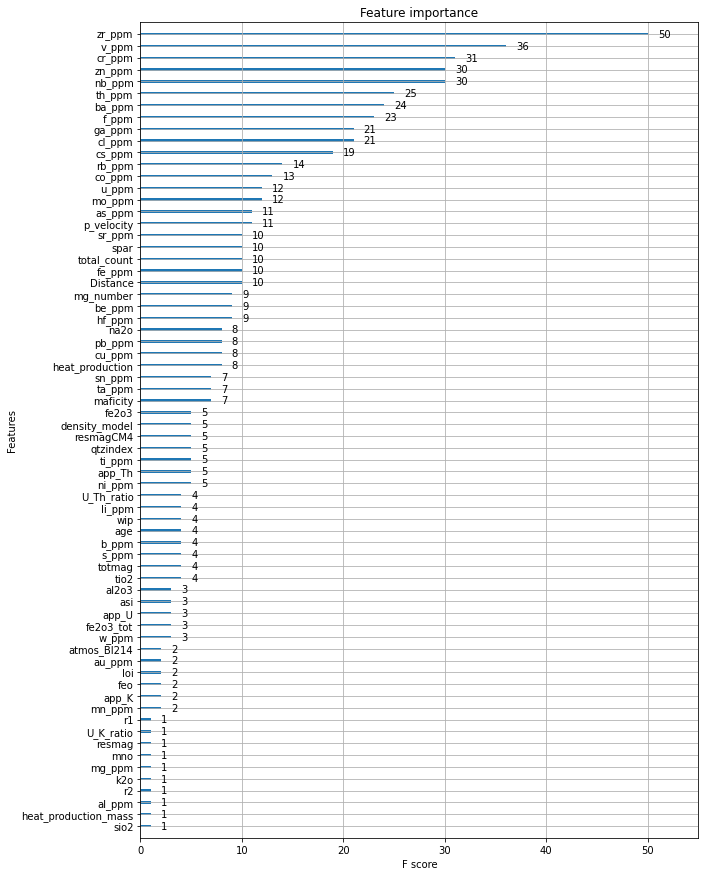

In [25]:
# plot feature importance using built-in function and looks @ all features
# plot feature importance
ax = xgboost.plot_importance(model)
fig = ax.figure
fig.set_size_inches(10, 15)

In [26]:
#use model to predict if rare earths in full dataset (even the rows that did not have rare earth data)
features_full_dataset = df3.drop(['rare_earth'], axis=1)
y_pred_all = model.predict(features_full_dataset)
#y_pred_all

In [27]:
#add the prediction array and latittude and longitude to a dataframe for plotting on a map
predict_full_dataset=features_full_dataset
predict_full_dataset['rare_earth_predict'] = y_pred_all.tolist()
predict_full_dataset['latitude']=df['latitude']
predict_full_dataset['longitude']=df['longitude']
predict_full_dataset['sample_id']=df['sample_id']
predict_full_dataset.head()

,quartz,feldspar,lithics,p_velocity,density_model,heat_production,heat_production_mass,f_ppm,cl_ppm,br__ppm,i_ppm,h_ppm,c_ppm,n_ppm,p_ppm,s_ppm,al_ppm,as_ppm,ag_ppm,au_ppm,b_ppm,ba_ppm,be_ppm,bi_ppm,ca_ppm,cd_ppm,co_ppm,cr_ppm,cs_ppm,cu_ppm,fe_ppm,ga_ppm,ge_ppm,hf_ppm,hg_ppm,in_ppm,ir_ppm,k_ppm,li_ppm,mg_ppm,mn_ppm,mo_ppm,na_ppm,ni_ppm,nb_ppm,os_ppm,pa_ppm,pb_ppm,pd_ppm,pt_ppm,rb_ppm,re_ppm,rh_ppm,ru_ppm,sb_ppm,se_ppm,si_ppm,sn_ppm,sr_ppm,ta_ppm,te_ppm,th_ppm,ti_ppm,tl_ppm,w_ppm,v_ppm,u_ppm,zn_ppm,zr_ppm,sio2,tio2,al2o3,cr2o3,fe2o3,fe2o3_tot,feo,feo_tot,mgo,cao,mno,nio,k2o,na2o,sro,p2o5,h2o_plus,h2o_minus,h2o_tot,co2,so3,bao,caco3,mgco3,loi,rb87_sr86,sr87_sr86,nd143_nd144,sm147_nd144,lu176_hf177,hf176_hf177,re187_os186,re187_os188,os187_os188,pb206_pb204,pb207_pb204,pb208_pb204,th232_pb204,th232_u238,u238_pb204,epsilon_hf,epsilon_nd,epsilon_sr,age,mg_number,fe_number,mali,asi,maficity,cia,wip,spar,qtzindex,r1,r2,totmag,resmag,resmagCM4,Distance,qual,app_K,app_U,app_Th,U_Th_ratio,U_K_ratio,Th_K_ratio,total_count,atmos_BI214,igneous,metamorphic,sedimentary,chemical,metaigneous,metaplutonic,metasedimentary,metavolcanic,plutonic,volcanic,,Other_time_period,Other_facies,rare_earth_predict,latitude,longitude,sample_id
80261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,-1.0,NaN,NaN,NaN,78.0,245.0,NaN,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.0,NaN,375.0,NaN,NaN,NaN,-10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.111,NaN,NaN,95.0,NaN,NaN,NaN,NaN,NaN,NaN,199.0,NaN,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.861588,1.089044,NaN,52.131205,NaN,-0.004805,0.219919,2.833779,NaN,54213.8,53640.0,304.0,1157.280330,682.0,131.0,28.0,39.0,0.7,0.2,0.3,1686.0,-99.9,1,0,0,0,0,0,0,0,0,1,0,1,0,0.0,37.25,-106.00,80325
80302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,8.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.0,NaN,NaN,25.0,NaN,NaN,7.0,NaN,NaN,894.0,NaN,NaN,NaN,NaN,-2.000,NaN,45.0,10.0,NaN,NaN,11.0,NaN,NaN,11.0,3.0,19.0,55.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.861588,1.089044,NaN,52.131205,NaN,-0.004805,0.219919,2.833779,NaN,55136.0,130.1,526.0,399.620166,0.0,2.5,3.4,9.7,0.3,1.4,3.9,2487.3,2.4,1,0,0,0,0,0,0,0,1,0,0,1,0,0.0,38.33,-105.50,80302
80303,NaN,NaN,NaN,7.068878,2923.239352,NaN,NaN,NaN,3660.0,NaN,NaN,NaN,NaN,NaN,NaN,304.0,NaN,NaN,NaN,NaN,NaN,541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,591.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.425045,0.739362,-6.120000,0.697295,0.322335,41.082734,71.762758,-0.235224,0.091750,1.461196,1.593819,54213.8,53640.0,304.0,1157.280330,682.0,131.0,28.0,39.0,0.7,0.2,0.3,1686.0,-99.9,1,0,0,0,0,0,0,0,0,1,0,1,0,0.0,37.25,-106.00,80303
80304,NaN,NaN,NaN,6.863169,2847.002910,NaN,NaN,NaN,3660.0,NaN,NaN,NaN,NaN,NaN,NaN,304.0,NaN,NaN,NaN,NaN,NaN,541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,591.0,83.14,0.93,9.14,NaN,1.31,1.65,0.31,NaN,0.08,0.08,0.01,NaN,0.15,0.03,NaN,0.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,0.474753,0.698810,NaN,NaN,0.226451,NaN,NaN,NaN,NaN,NaN,0.630139,54602.0,400.0,726.2,1032.798130,-9999.0,133.8,24.2,244.3,-99.9,-99.9,-99.9,-9999.9,-99.9,1,0,0,0,0,0,0,0,0,1,0,1,0,0.0,37.14,-105.8

In [28]:
features_full_dataset['rare_earth_predict'].value_counts()

0.0    30012
1.0      626
Name: rare_earth_predict, dtype: int64

In [29]:
#write all data to csv
#pd.merge(df1, df2, on = "fruit", how = "inner") 
merge_df1=features_full_dataset[['sample_id','rare_earth_predict', 'latitude','longitude','au_ppm','ag_ppm']]
merge_df2 = df2[['rare_earth','sample_id']]
merge_df3 = df[['sample_id','sc_ppm', 'y_ppm', 'la_ppm', 'ce_ppm', 'pr_ppm', 'nd_ppm', 'sm_ppm', 'eu_ppm', 'gd_ppm', 'tb_ppm', 'dy_ppm', 'ho_ppm', 'er_ppm', 'tm_ppm', 'yb_ppm', 'lu_ppm','totmag','resmag','resmagCM4','qual','app_K','app_U','app_Th','U_Th_ratio', 'U_K_ratio','Th_K_ratio']]

output_df_full = merge_df1.merge(merge_df3, how ='inner', on='sample_id')
output_df_full=output_df_full.merge(merge_df2,how='inner', on='sample_id')
output_df_full.describe()



,sample_id,rare_earth_predict,latitude,longitude,au_ppm,ag_ppm,sc_ppm,y_ppm,la_ppm,ce_ppm,pr_ppm,nd_ppm,sm_ppm,eu_ppm,gd_ppm,tb_ppm,dy_ppm,ho_ppm,er_ppm,tm_ppm,yb_ppm,lu_ppm,totmag,resmag,resmagCM4,qual,app_K,app_U,app_Th,U_Th_ratio,U_K_ratio,Th_K_ratio,rare_earth
count,30638.000000,30638.000000,30638.000000,30638.000000,46.000000,142.000000,338.000000,447.000000,387.000000,377.000000,190.000000,296.000000,247.000000,258.000000,207.000000,220.000000,191.000000,172.000000,175.000000,92.000000,279.000000,220.000000,30638.000000,30638.000000,30638.000000,30638.000000,30638.000000,30638.000000,30638.000000,30638.000000,30638.000000,30638.000000,30638.000000
mean,583764.103401,0.020432,38.964315,-106.740050,610.272193,2.809270,18.360497,33.298886,66.833070,128.698677,18.740032,56.357782,9.673632,2.255644,8.547354,1.063381,6.137105,1.156411,3.387819,0.507202,3.033267,0.455785,54741.681334,9910.968125,-6.726904,-335.260591,39.413496,7.996322,30.393851,348.457798,11.343205,345.904070,4.035790
std,140661.842809,0.141476,1.421959,1.413388,3342.896358,15.848173,49.235706,33.321476,213.551764,444.402189,72.582798,196.719793,27.724429,6.757478,14.919678,2.213932,7.802584,1.630005,3.740439,0.673218,2.802426,0.434516,895.438573,21157.926120,586.299470,2128.540188,72.660194,13.784059,48.633687,1873.985207,499.873851,1829.752246,110.128826
min,80302.000000,0.000000,36.000000,-110.009000,-0.050000,-20.000000,-5.000000,-5.000000,-35.000000,-35.000000,-68.000000,-30.000000,-46.000000,-1.000000,-0.500000,-22.000000,-10.000000,-10.000000,-4.600000,-2.200000,-1.000000,-0.100000,52056.800000,-4125.200000,-3827.000000,-9999.000000,-10.800000,-139.400000,-13.800000,-999.900000,-999.900000,-999.900000,-52.000000
25%,494084.250000,0.000000,37.866700,-107.779000,0.001000,-0.500000,5.000000,15.000000,16.950000,31.100000,4.025000,15.000000,3.318197,0.700000,3.705000,0.500000,2.780000,0.528000,1.580000,0.167500,1.500000,0.200000,54150.525000,-488.700000,-154.000000,0.000000,1.500000,1.300000,6.700000,0.100000,0.100000,0.700000,0.000000
50%,595075.500000,0.000000,38.920000,-106.539500,0.004000,0.010000,11.000000,25.000000,36.000000,68.400000,7.995000,29.000000,5.800000,1.106000,5.310000,0.796634,4.500000,0.875000,2.600000,0.387000,2.490000,0.350000,54772.950000,-326.800000,-9.300000,0.000000,2.300000,2.900000,11.300000,0.300000,0.700000,4.100000,0.000000
75%,676912.750000,0.000000,40.000000,-105.545000,0.051500,0.200000,22.150000,38.000000,55.527078,107.000000,12.000000,45.250000,8.800000,1.887500,8.600000,1.225000,6.950000,1.310000,3.705000,0.726072,3.900000,0.581750,55321.375000,105.500000,178.200000,1.000000,35.800000,8.400000,32.000000,0.400000,1.600000,5.700000,0.000000
max,979662.000000,1.000000,42.009600,-102.000000,22000.000000,122.400000,838.000000,327.000000,2275.000000,4811.000000,572.000000,1928.000000,244.000000,60.300000,112.000000,11.300000,57.900000,11.900000,32.700000,4.550000,27.400000,3.650000,61757.500000,56015.000000,5609.900000,1111.000000,451.500000,1222.000000,337.200000,9999.900000,9999.900000,9999.900000,10218.596000


In [45]:
output_df_full.to_csv('Colorado_output.csv', index=False)

In [ ]:
#output the Colorado results
#conn_string= databasestringpasswordhere
#alchemyEngine=create_engine(conn_string)

# Connect to PostgreSQL server
#dbConnection = alchemyEngine.connect();
#output_df_full.to_sql('output_colorado', con=alchemyEngine)
#dbConnection.close();

In [31]:
#read in shape files with world map
map = gpd.read_file('.\\maps\\World_Countries__Generalized_.shp')

In [32]:
#create geometry points with lat & long
geometry = [Point(xy) for xy in zip(features_full_dataset["longitude"], features_full_dataset["latitude"])]
geometry[:3]
#crs = coordinated reference system
crs = {'init': 'epsg:4326'}
geo_df=gpd.GeoDataFrame(features_full_dataset, crs=crs, geometry = geometry) 

Text(0.5, 1.0, 'Predicted Rare Earth Concentrations < 100 ppm')

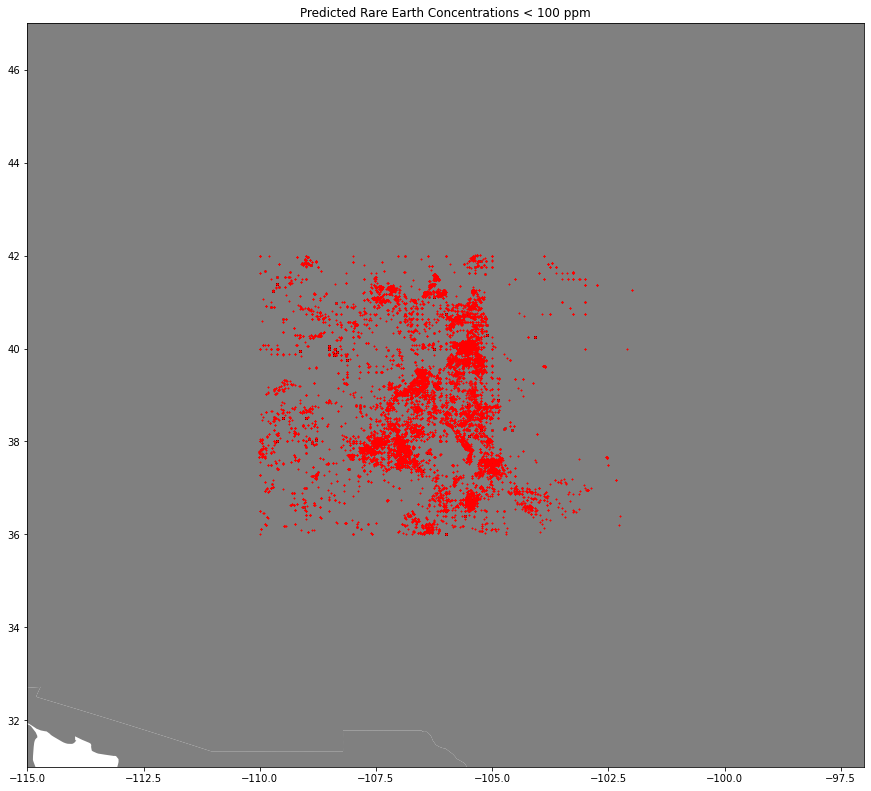

In [37]:
#create map with no rare earth points 
fig,ax=plt.subplots(figsize=(15,15))
map.plot(ax=ax, color="grey")
minx, miny, maxx, maxy = geo_df.total_bounds
minx=minx-5
miny=miny-5
maxx=maxx+5
maxy=maxy+5
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

geo_df[geo_df['rare_earth_predict']==0].plot(ax=ax, markersize=1, color="red", marker='x')
plt.title('Predicted Rare Earth Concentrations < 100 ppm')

Text(0.5, 1.0, 'Predicted Rare Earth Concentrations > 100 ppm')

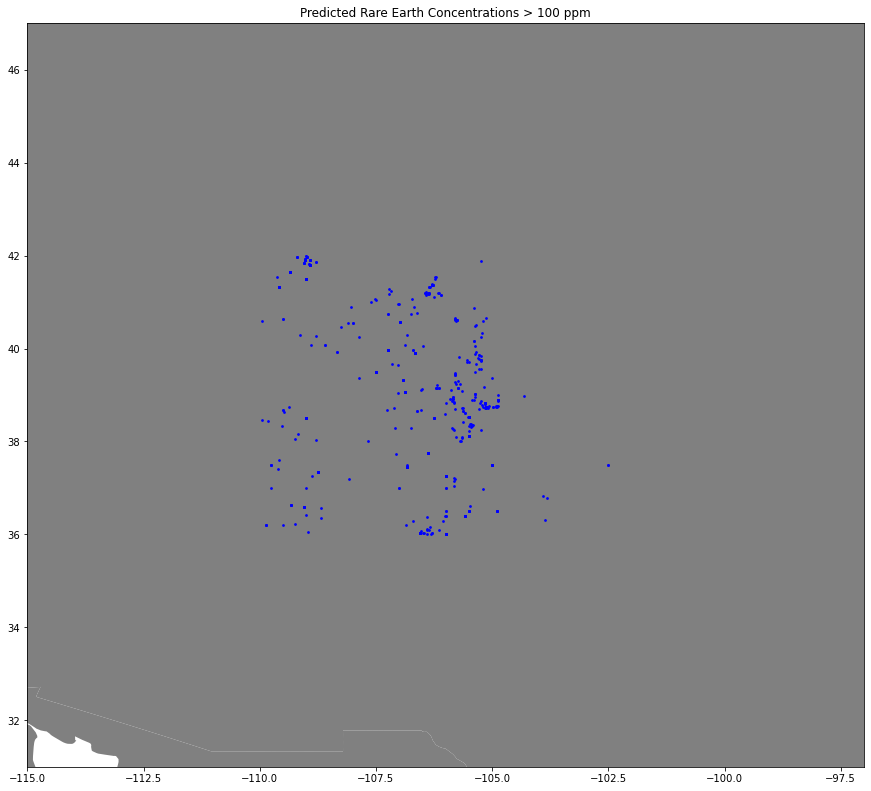

In [38]:
#create map with rare earth points @ cutoff >100 ppm value
fig,ax=plt.subplots(figsize=(15,15))
map.plot(ax=ax, color="grey")
minx, miny, maxx, maxy = geo_df.total_bounds
minx=minx-5
miny=miny-5
maxx=maxx+5
maxy=maxy+5
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
geo_df[geo_df['rare_earth_predict']==1].plot(ax=ax, markersize=3, color="blue", marker ="o")
plt.title('Predicted Rare Earth Concentrations > 100 ppm')

In [35]:
#create geometry points with lat & long
geometry2 = [Point(xy) for xy in zip(mines["longitude"], mines["latitude"])]
geometry2[:3]
#crs = coordinated reference system
crs = {'init': 'epsg:4326'}

#the additional USGS dataset with known rare earths
geo_df2=gpd.GeoDataFrame(mines, crs=crs, geometry = geometry2) 

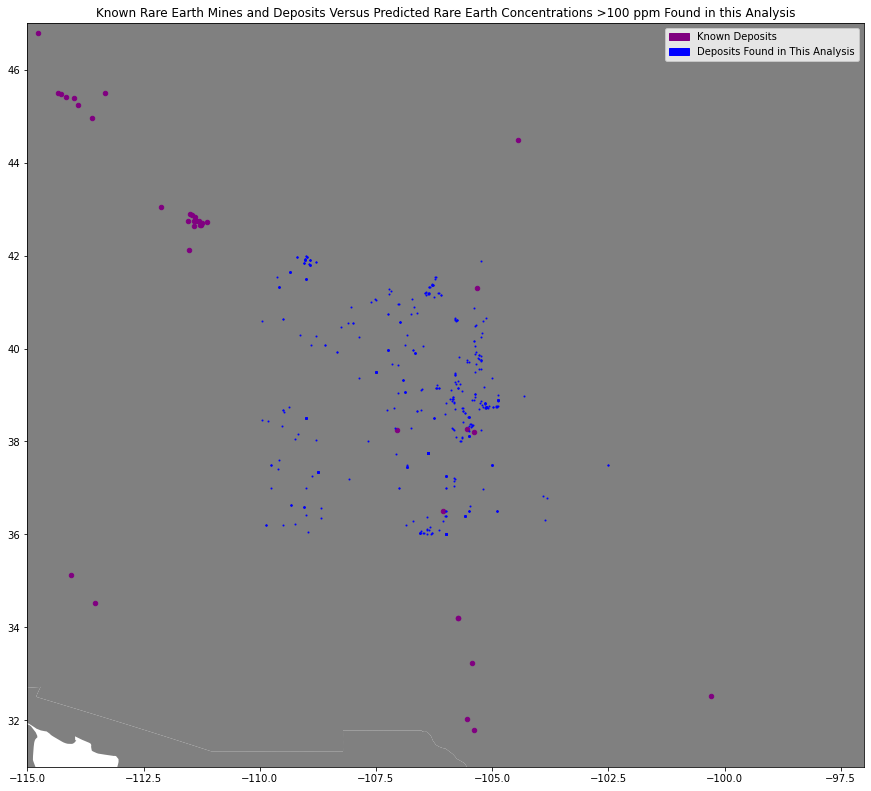

In [39]:
#df2 is known deposits  (purple)
#blue dots are additional potential deposits from this analysis
fig,ax=plt.subplots(figsize=(15,15))

plt.title('Known Rare Earth Mines and Deposits Versus Predicted Rare Earth Concentrations >100 ppm Found in this Analysis')

map.plot(ax=ax, color="grey")
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plot_A = geo_df2[geo_df2['latitude']>-100].plot(ax=ax, markersize=20, color="purple", marker='o', label = "Known Deposits")
plot_B = geo_df[geo_df['rare_earth_predict']==1].plot(ax=ax, markersize=1, color="blue", marker ="o", label = "Rare Earth Found in Analysis")

import matplotlib.patches as mpatches
purple_patch = mpatches.Patch(color='purple', label='Known Deposits')
blue_patch = mpatches.Patch(color='blue', label='Deposits Found in This Analysis')
plt.legend(handles=[purple_patch, blue_patch])